In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.nn import Module, Sequential, Linear, Conv2d, ReLU, Tanh, CrossEntropyLoss
from torch.utils.data import DataLoader

from torchvision.transforms import transforms
import torchvision.datasets as datasets
from torch import optim

from torch.distributions.multivariate_normal import MultivariateNormal

from torchinfo import summary

from models import MLP

from RectifiedFlow import RectifiedFlow, train_rectified_flow

In [2]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(device)

cuda


In [3]:
batch_size = 128   #len: 5918
num_samples_train = 5000

transform = transforms.Compose([
    #transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
    ])

train_dataset = datasets.MNIST(
    "./data/MNIST",
    download=True,
    train=True,
    transform=transform,
)

train_dataset.data = train_dataset.data[train_dataset.targets == 6]
train_dataset.targets = train_dataset.targets[train_dataset.targets == 6]

test_dataset = datasets.MNIST(
    "./data/MNIST",
    download=True,
    train=False,
    transform=transform,
)

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=1,
    pin_memory=True,
)

test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=1,
    pin_memory=True,
)

In [4]:
input_shape = (batch_size, 2, 32, 32)

In [5]:
v_model_1 = MLP(28*28, 10, 28*60)
rectified_flow_1 = RectifiedFlow(v_model_1, device)

In [6]:
optimizer_1 = torch.optim.Adam(rectified_flow_1.v_model.parameters(), lr=5e-3)
# optim.beta1 = 0.9
# optim.eps = 1e-8
#optimizer_1 = torch.optim.SGD(rectified_flow_1.v_model.parameters(), lr=5e-3, momentum=0.99)
scheduler_1 = optim.lr_scheduler.ReduceLROnPlateau(optimizer_1, factor=0.8, patience=80, verbose=True)

In [7]:
rectified_flow = train_rectified_flow(rectified_flow_1, optimizer_1, scheduler_1, train_dataloader, device, epochs=60)

Epoch 00680: reducing learning rate of group 0 to 4.0000e-03.
Epoch 01224: reducing learning rate of group 0 to 3.2000e-03.
Epoch 01344: reducing learning rate of group 0 to 2.5600e-03.
Epoch 01425: reducing learning rate of group 0 to 2.0480e-03.
Epoch 01528: reducing learning rate of group 0 to 1.6384e-03.
Epoch 01819: reducing learning rate of group 0 to 1.3107e-03.
Epoch 01930: reducing learning rate of group 0 to 1.0486e-03.
Epoch 02068: reducing learning rate of group 0 to 8.3886e-04.
Epoch 02259: reducing learning rate of group 0 to 6.7109e-04.
Epoch 02340: reducing learning rate of group 0 to 5.3687e-04.
Epoch 02502: reducing learning rate of group 0 to 4.2950e-04.
Epoch 02583: reducing learning rate of group 0 to 3.4360e-04.
Epoch 02664: reducing learning rate of group 0 to 2.7488e-04.
Epoch 02745: reducing learning rate of group 0 to 2.1990e-04.


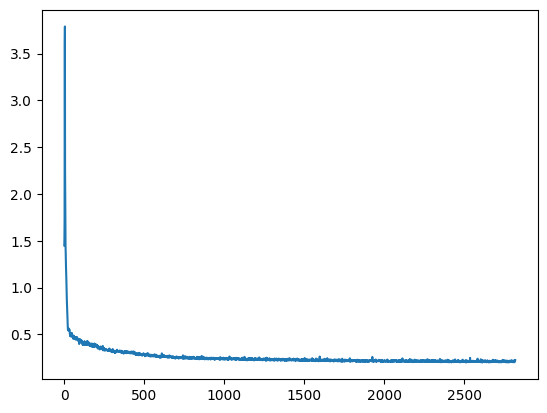

In [8]:
plt.plot(rectified_flow_1.loss_curve)
plt.show()

In [9]:
torch.save(rectified_flow_1, "./models/MNIST_newest2.pth")

In [10]:
rectified_flow_1 = torch.load("./models/MNIST_newest2.pth")

tensor([[-1.2141e+00, -1.1713e+00, -1.2359e+00, -1.2445e+00, -1.0676e+00,
         -2.2192e-01, -7.1338e-01, -7.7078e-01, -1.1062e+00, -7.4350e-01,
         -1.4547e+00, -1.6258e+00, -1.0116e+00, -1.3188e+00, -7.3132e-01,
         -6.4844e-01, -1.3516e+00, -1.0361e+00, -7.8793e-01, -1.6563e+00,
         -5.5383e-01, -1.2982e-01, -1.0035e+00, -9.2949e-01, -1.0666e+00,
         -8.8653e-01, -4.3511e-01, -1.1194e+00, -8.7877e-01, -7.9446e-01,
         -7.8939e-01, -1.1190e+00, -5.9690e-01, -1.3497e+00, -1.1750e+00,
         -1.4249e+00, -8.4532e-01, -8.1442e-01, -1.1922e+00, -9.4242e-01,
         -1.7243e+00, -6.6747e-01, -1.1594e+00, -6.5791e-01, -7.4428e-01,
         -1.0455e+00, -8.1870e-01, -6.8708e-01, -6.8339e-01, -1.3923e+00,
         -1.0340e+00, -1.3919e+00, -1.1554e+00, -2.3835e-01, -1.7788e+00,
         -6.9170e-01, -1.6478e+00, -8.0403e-01, -3.0634e-01, -1.3817e+00,
         -1.2212e+00, -1.6072e+00, -1.2856e+00, -6.9266e-01, -5.0787e-01,
         -1.5063e+00, -5.8796e-01, -7.

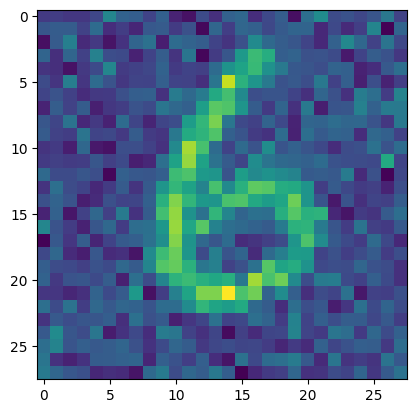

In [11]:
rectified_flow_1.v_model.eval()
img_init = torch.randn(1,28*28).to(device) / 3

img = rectified_flow_1.sample_ode(img_init, 100)

print(img[-1])

plt.imshow(img[-1][0].reshape(28,28).detach().cpu().numpy())
plt.show()

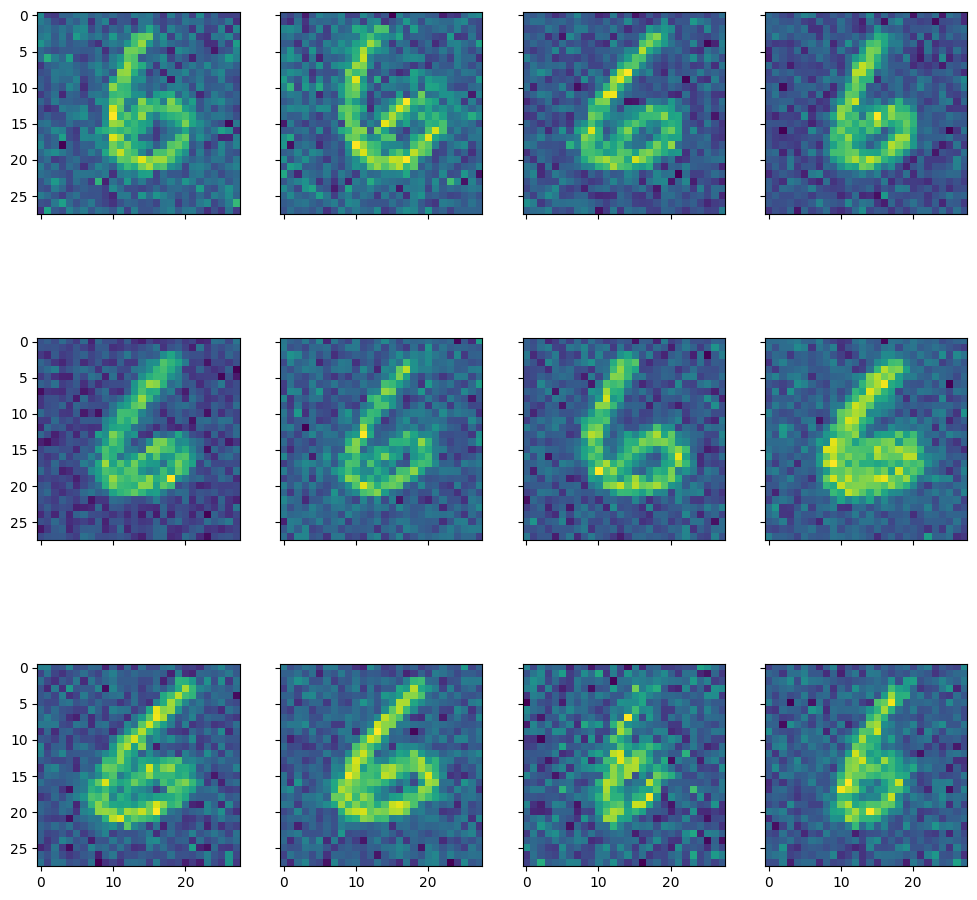

In [12]:
rectified_flow_1.v_model.eval()
rows = 3
columns = 4
size = (12, 12)
fig, ax = plt.subplots(rows, columns, figsize=(size), sharex=True, sharey=True)

for row in range(rows):
    for column in range(columns):
        img_init = torch.randn(1,28*28).to(device) / 3

        img = rectified_flow_1.sample_ode(img_init, 100)[-1][0].reshape(28,28).detach().cpu().numpy()
        ax[row, column].imshow(img)

plt.show()